In this notebook, we'll revisit our MNIST GAN example and try to improve our approach.

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

First, a couple of definitions and helpers, similar to the previous notebook. We do make sure to add in the channel dimension for our images.

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=-1)
X_test  = np.expand_dims(X_test, axis=-1)

In [ ]:
def make_latent_samples(n_samples, sample_size):
  return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [ ]:
latent_size = 128
img_dims    = X_train[0].shape

In [ ]:
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

In [ ]:
def make_labels(size):
  return np.ones([size, 1]), np.zeros([size, 1])

We now define the generator and discriminator. We'll use (de)convolutions this time around for the generator and discriminator respectively, and also use batch normalization.

In [ ]:
generator = Sequential([
  Dense(784, input_shape=(latent_size,)),
  Reshape(target_shape=(7, 7, 16)),
  BatchNormalization(),
  LeakyReLU(alpha=0.02),
  Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
  BatchNormalization(),
  LeakyReLU(alpha=0.02),
  Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
  Activation('tanh')
])

generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 784)               101136    
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_23 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 32)      

In [ ]:
discriminator = Sequential([        
  Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=img_dims),
  LeakyReLU(alpha=0.02),
  Conv2D(16, kernel_size=5, strides=2, padding='same'),   
  BatchNormalization(),
  LeakyReLU(alpha=0.02),
  Flatten(),
  Dense(784),
  BatchNormalization(),
  LeakyReLU(alpha=0.02),
  Dense(1),
  Activation('sigmoid')        
])

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 16)          12816     
_________________________________________________________________
batch_normalization_24 (Batc (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 784)             

We compile, set the learning rate, and define processing functions, similar to before:

In [ ]:
gan = Sequential([ generator, discriminator ])

gan.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 28, 28, 1)         114961    
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 633073    
Total params: 748,034
Trainable params: 746,338
Non-trainable params: 1,696
_________________________________________________________________


In [ ]:
gan.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
discriminator.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')

In [ ]:
def preprocess(x):    
  x = np.float64(x)
  x = (x / 255 - 0.5) * 2
  x = np.clip(x, -1, 1)
  return x

In [ ]:
def deprocess(x):
  x = (x / 2 + 0.5) * 255
  x = np.clip(x, 0, 255)
  x = np.uint8(x)
  x = x.squeeze()
  return x

In [ ]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

And we are ready to train again:

In [ ]:
epochs          = 100
batch_size      = 64
eval_size       = 16
smooth          = 0.1

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

losses = []

make_trainable(discriminator, False)
make_trainable(generator, True)
    
for e in range(epochs):

  # For each batch of real examples
  for i in range(len(X_train_real)//batch_size):
    X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
    
    # Generate the same amount of fake examples from latent space
    latent_samples = make_latent_samples(batch_size, latent_size)
    X_batch_fake = generator.predict_on_batch(latent_samples)
    
    # Train the discriminator only, ignore the generator, using label smoothing for the real examples
    make_trainable(discriminator, True)
    discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    discriminator.train_on_batch(X_batch_fake, y_train_fake)

    # Train the generator using the full model, but with frozen weights for the discriminator part
    make_trainable(discriminator, False)
    gan.train_on_batch(latent_samples, y_train_real)
  
  # Evaluate how we're doing so far
  X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

  latent_samples = make_latent_samples(eval_size, latent_size)
  X_eval_fake = generator.predict_on_batch(latent_samples)

  d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
  d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
  
  g_loss  = gan.test_on_batch(latent_samples, y_eval_real)
  losses.append((d_loss, g_loss))
  
  if e % 10 == 0:
    print("Epoch: {:>3}/{} | discriminator loss: {:>6.4f} | generator loss: {:>6.4f}".format(e+1, epochs, d_loss, g_loss))    

Epoch:   1/100 | discriminator loss: 2.7739 | generator loss: 1.1031
Epoch:  11/100 | discriminator loss: 2.9619 | generator loss: 0.1091
Epoch:  21/100 | discriminator loss: 12.8555 | generator loss: 12.4842
Epoch:  31/100 | discriminator loss: 5.5742 | generator loss: 6.8538
Epoch:  41/100 | discriminator loss: 9.6434 | generator loss: 7.7731
Epoch:  51/100 | discriminator loss: 5.3445 | generator loss: 6.1823
Epoch:  61/100 | discriminator loss: 5.9465 | generator loss: 4.0174
Epoch:  71/100 | discriminator loss: 5.0828 | generator loss: 7.2534
Epoch:  81/100 | discriminator loss: 12.8264 | generator loss: 8.9459
Epoch:  91/100 | discriminator loss: 9.0246 | generator loss: 10.1481


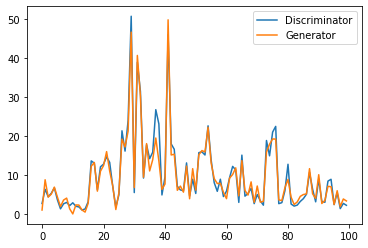

In [ ]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.legend()
plt.show()

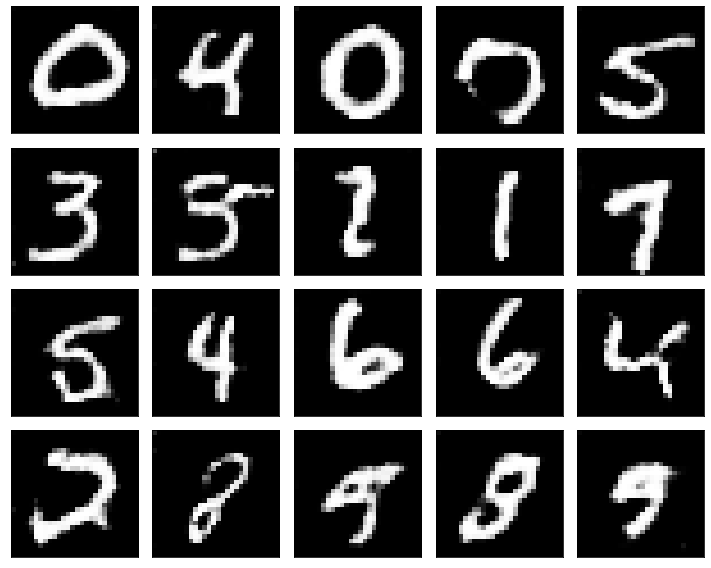

In [ ]:
latent_samples   = make_latent_samples(20, latent_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
  img = deprocess(generated_digits[i])
  plt.subplot(4, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

As can be seen, this result already looks way better.